In [1]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 28.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, MaxAbsScaler, RobustScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## Getting data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
path = "/content/drive/MyDrive/Colab Notebooks/bus_arr/"
df = pd.read_csv(path + "ready_data.csv")

<ipython-input-30-77873675e141>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "ready_data.csv")


In [31]:
df.head()

,Unnamed: 0,service_date,route_id,direction_id,stop_id,time_point_id,time_point_order,point_type,scheduled,actual,scheduled_time,actual_time,day_of_week,delay,route_id_c,direction_id_c,time_point_id_c,point_type_c,day_of_week_c
0,0,2024-01-01,01,Inbound,110,hhgat,1,Startpoint,1900-01-01 06:05:00+00:00,1900-01-01 06:05:03+00:00,605,605,Monday,3.0,0,0,210,2,1
1,1,2024-01-01,01,Inbound,67,maput,2,Midpoint,1900-01-01 06:09:00+00:00,1900-01-01 06:08:17+00:00,609,608,Monday,-43.0,0,0,267,1,1
2,2,2024-01-01,01,Inbound,72,cntsq,3,Midpoint,1900-01-01 06:12:00+00:00,1900-01-01 06:12:00+00:00,612,612,Monday,0.0,0,0,115,1,1
3,3,2024-01-01,01,Inbound,75,mit,4,Midpoint,1900-01-01 06:15:00+00:00,1900-01-01 06:16:50+00:00,615,616,Monday,110.0,0,0,292,1,1
4,4,2024-01-01,01,Inbound,79,hynes,5,Midpoint,1900-01-01 06:19:00+00:00,1900-01-01 06:20:45+00:00,619,620,Monday,105.0,0,0,232,1,1


In [32]:
np.random.seed(42)
tf.random.set_seed(42)

## Drop columns that I found irrelevant and those that are not numerical and changing delay to minutes (other stuff such as encoding, etc.)

In [33]:
df.drop(['service_date', 'route_id', 'direction_id', 'time_point_id', 'point_type', 'scheduled', 'actual', 'day_of_week'], axis=1, inplace=True)
df['delay'] = df['delay'].astype(int)

In [34]:
df.drop(['Unnamed: 0', 'actual_time', 'time_point_id_c'], axis=1, inplace=True)

In [35]:
df['delay'] = df['delay'] / 60

In [36]:
df.rename(columns={'route_id_c': 'route_id', 'direction_id_c': 'direction_id',
                   'point_type_c': 'point_type', 'day_of_week_c': 'day_of_week'}, inplace=True)

In [38]:
df['scheduled_hour'] = df['scheduled_time'] // 100
df['scheduled_minute'] = df['scheduled_time'] % 100

In [39]:
df.drop(['scheduled_time', 'time_point_order', 'point_type'], axis=1, inplace=True)

In [40]:
df.head()

,stop_id,delay,route_id,direction_id,day_of_week,scheduled_hour,scheduled_minute
0,110,0.050000,0,0,1,6,5
1,67,-0.716667,0,0,1,6,9
2,72,0.000000,0,0,1,6,12
3,75,1.833333,0,0,1,6,15
4,79,1.750000,0,0,1,6,19


```
```
```
```
```
```


## Dividing dataset into train and test

In [64]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [65]:
X_train = train.drop(['delay'], axis=1)
y_train = train['delay']
X_test = test.drop(['delay'], axis=1)
y_test = test['delay']
# Check for NaN values in the DataFrame
print("NaNs in train DataFrame:\n", train.isna().sum())

NaNs in train DataFrame:
 stop_id             0
delay               0
route_id            0
direction_id        0
day_of_week         0
scheduled_hour      0
scheduled_minute    0
dtype: int64


In [48]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## Models
### Linear Regression

In [51]:
print("Training Linear Regression...")
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)
rmse_lin = rmse(y_test, y_pred_lin)
mae_lin = mean_absolute_error(y_test, y_pred_lin)

print(f"Linear Regression Test RMSE: {rmse_lin:.4f}")
print(f"Linear Regression Test MAE:  {mae_lin:.4f}")

cv_lin = cross_val_score(lin_reg, X_train, y_train, cv=KFold(5, shuffle=True, random_state=42), scoring='neg_mean_squared_error')
cv_lin_rmse = np.sqrt(-cv_lin.mean())
print(f"Linear Regression 5-Fold CV RMSE: {cv_lin_rmse:.4f}\n")

Training Linear Regression...
Linear Regression Test RMSE: 6.1017
Linear Regression Test MAE:  4.1920
Linear Regression 5-Fold CV RMSE: 6.1133



### Random Forest

In [52]:
print("Training Random Forest Regressor...")
rf_reg = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)
rmse_rf = rmse(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest Test RMSE: {rmse_rf:.4f}")
print(f"Random Forest Test MAE:  {mae_rf:.4f}")

Training Random Forest Regressor...
Random Forest Test RMSE: 5.3264
Random Forest Test MAE:  3.5640


### XGBoost

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
print("Training XGBoost Regressor...")
xgb_reg = XGBRegressor(n_estimators=100, random_state=42, verbosity=0, device=device)
xgb_reg.fit(X_train, y_train)

y_pred_xgb = xgb_reg.predict(X_test)
rmse_xgb = rmse(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test RMSE: {rmse_xgb:.4f}")
print(f"XGBoost Test MAE:  {mae_xgb:.4f}")
print(f"XGBoost Test R²:   {r2_xgb:.4f}")

Training XGBoost Regressor...
XGBoost Test RMSE: 5.2691
XGBoost Test MAE:  3.6030
XGBoost Test R²:   0.2630


## Neural Network models
### LSTM nn

In [67]:
n_features = X_train.shape[1]

# First, split X_train into a (reduced) training set and a validation set for early stopping.
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert training and validation sets to tensors
X_train_sub_tensor = torch.tensor(X_train_sub.values.reshape(X_train_sub.shape[0], 1, n_features), dtype=torch.float32)
y_train_sub_tensor = torch.tensor(y_train_sub.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values.reshape(X_val.shape[0], 1, n_features), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Also convert the test set to tensors
X_test_tensor = torch.tensor(X_test.values.reshape(X_test.shape[0], 1, n_features), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_sub_tensor, y_train_sub_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [70]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        out = self.fc(lstm_out[:, -1, :])
        return out.squeeze()

In [72]:
hidden_size = 75
model = LSTMRegressor(input_size=n_features, hidden_size=hidden_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [73]:
num_epochs = 10
patience = 5
best_loss = np.inf
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}")

    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(best_model_state)

Epoch 1/10 - Train Loss: 23.972915
Epoch 2/10 - Train Loss: 23.804105
Epoch 3/10 - Train Loss: 23.870343
Epoch 4/10 - Train Loss: 23.735984
Epoch 5/10 - Train Loss: 23.704693
Epoch 6/10 - Train Loss: 23.670189
Epoch 7/10 - Train Loss: 23.637963
Epoch 8/10 - Train Loss: 23.654058
Epoch 9/10 - Train Loss: 23.605806
Epoch 10/10 - Train Loss: 23.568846


<All keys matched successfully>

In [74]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.to(device))
    test_loss = criterion(test_outputs, y_test_tensor.to(device)).item()
rmse_lstm = np.sqrt(test_loss)

lstm_predictions = test_outputs.cpu().numpy() if device.type == 'cuda' else test_outputs.numpy()
mae_lstm = mean_absolute_error(y_test, lstm_predictions)

print(f"LSTM Test RMSE: {rmse_lstm:.4f}")
print(f"LSTM Test MAE:  {mae_lstm:.4f}")

LSTM Test RMSE: 4.8508
LSTM Test MAE:  3.6277


### CNN

In [75]:
class CNNRegressor(nn.Module):
    def __init__(self, n_features):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, padding='same')
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * (n_features // 2), 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze()

In [76]:
model_cnn = CNNRegressor(n_features).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0005)

In [77]:
num_epochs = 10
patience = 5
best_loss = np.inf
patience_counter = 0

for epoch in range(num_epochs):
    model_cnn.train()
    train_losses = []

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f}")

    if avg_train_loss < best_loss:
        best_val_loss = avg_train_loss
        patience_counter = 0
        best_model_state = model_cnn.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

model_cnn.load_state_dict(best_model_state)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(


Epoch 1/10 - Train Loss: 87.488328
Epoch 2/10 - Train Loss: 23.261543
Epoch 3/10 - Train Loss: 23.025711
Epoch 4/10 - Train Loss: 22.871247
Epoch 5/10 - Train Loss: 22.701432
Epoch 6/10 - Train Loss: 22.571292
Epoch 7/10 - Train Loss: 22.434854
Epoch 8/10 - Train Loss: 22.365375
Epoch 9/10 - Train Loss: 22.254286
Epoch 10/10 - Train Loss: 22.183499


<All keys matched successfully>

In [78]:
model_cnn.eval()
with torch.no_grad():
    test_outputs = model_cnn(X_test_tensor.to(device))
    test_loss = criterion(test_outputs, y_test_tensor.to(device)).item()
rmse_cnn = np.sqrt(test_loss)

cnn_predictions = test_outputs.cpu().numpy() if device.type == 'cuda' else test_outputs.numpy()
mae_cnn = mean_absolute_error(y_test, cnn_predictions)

print(f"CNN Test RMSE: {rmse_cnn:.4f}")
print(f"CNN Test MAE:  {mae_cnn:.4f}")

CNN Test RMSE: 4.6956
CNN Test MAE:  3.4668


In [79]:
print("----- Model Comparison (Test Metrics) -----")
print(f"Linear Regression:      RMSE={rmse_lin:.4f}, MAE={mae_lin:.4f}")
print(f"Random Forest:          RMSE={rmse_rf:.4f}, MAE={mae_rf:.4f}")
print(f"XGBoost:                RMSE={rmse_xgb:.4f}, MAE={mae_xgb:.4f}")
print(f"LSTM Neural Network:    RMSE={rmse_lstm:.4f}, MAE={mae_lstm:.4f}")
print(f"CNN:                    RMSE={rmse_cnn:.4f}, MAE={mae_cnn:.4f}")

----- Model Comparison (Test Metrics) -----
Linear Regression:      RMSE=4.8835, MAE=3.6424
Random Forest:          RMSE=5.3264, MAE=3.5640
XGBoost:                RMSE=5.2691, MAE=3.6030
LSTM Neural Network:    RMSE=4.8508, MAE=3.6277
CNN:                    RMSE=4.6956, MAE=3.4668


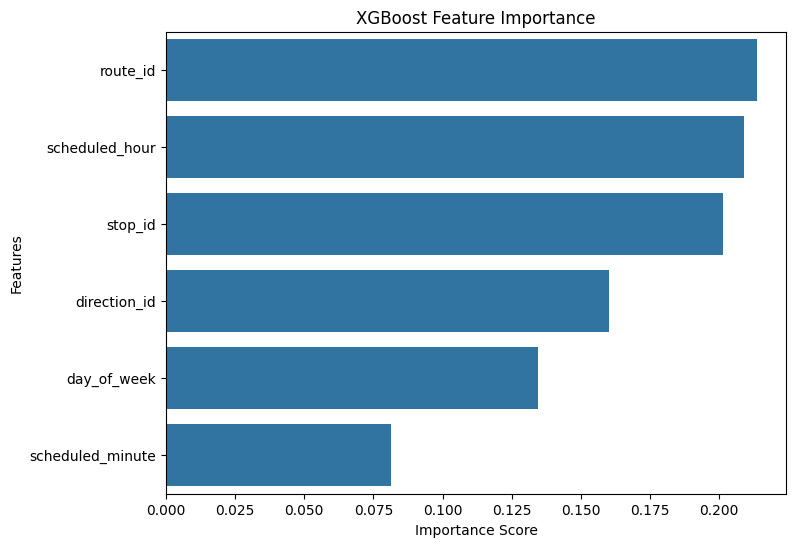

In [80]:
feature_importance = pd.Series(xgb_reg.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()